In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('./')

file_list = drive.ListFile({'q': "title = 'Neural_Nets-demo'"}).GetList()
ignore = ['.ipynb_checkpoints','__pycache__','core','run_','-ubyte.gz']

subdirs = file_list
subdirs[0]['path'] = local_download_path
subdirs[0]['title'] = ''

def retrieve_folder_files(path_to_folder, folder):
  
    files = drive.ListFile({'q': "'"+folder['id']+"' in parents"}).GetList()
    
    try:
      os.makedirs(os.path.join(path_to_folder,folder['title']))
    except: pass
    
    subdirs = []
    
    for file in files:
      
      #print(file['title'],path_to_folder)
      if all(s not in file['title'] for s in ignore) and all(s not in path_to_folder for s in ignore):
      
        if file['mimeType'][-6:] != 'folder':
          fname = os.path.join(os.path.join(path_to_folder, folder['title']),file['title'])
          print('Saving file:', fname)
          f_ = drive.CreateFile({'id': file['id']})
          f_.GetContentFile(fname)

        else:
          file['path'] = os.path.join(path_to_folder, folder['title'])
          subdirs.append(file)
    
    return(subdirs)

while len(subdirs) > 0:
  
  ssubdirs = []
  
  for folder in subdirs:
    #print(os.path.join(folder['path'], folder['title']))
    ssubdirs += (retrieve_folder_files(folder['path'], folder))
      
  subdirs = ssubdirs

./
Saving file: ./Basic_MNIST.ipynb
Saving file: ./Basic_MNIST-keasy.ipynb
Saving file: ./visualization_funcs.py
Saving file: ./Conv_MNIST.ipynb
./pytorch_models
Saving file: ./pytorch_models/Conv_MNIST-p.ipynb
Saving file: ./pytorch_models/Basic_MNIST-p.ipynb
./MNIST_data
Saving file: ./MNIST_data/sprite_1024.png
Saving file: ./MNIST_data/labels_1024.tsv
./tb_models
Saving file: ./tb_models/Conv_MNIST-tb.ipynb
Saving file: ./tb_models/Basic_MNIST-tb.ipynb
./keras_models
Saving file: ./keras_models/Conv_MNIST-k.ipynb
Saving file: ./keras_models/Basic_MNIST-k.ipynb
./logdir


# MNIST Handwritten Digits Classifier

We are going to predict the handwritten digit (from 0 to 9) in an image.

It will use a 1 layer Neural Network.

What we will discuss:
- Data
    - arrays ([Intro to NumPy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html))
    - data/datasets for ML
- Basic linear algebra ([Intro to lin alg](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab), [Run through of lin alg for ML](http://www.deeplearningbook.org/contents/linear_algebra.html))
    - scalars, vectors, matrices and tensors
    - matrix multiplication
- Neural Networks ([Intro to NNs](https://www.youtube.com/watch?v=ILsA4nyG7I0), [The NN Farm](http://www.asimovinstitute.org/neural-network-zoo/))
    - most basic structure
    - inputs/outputs
    - variables
    - training
- Optimization Technique ([Intro to Gradient descent and Back prop](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi))
    - gradient descent
    - back propagation
- Tensorflow Basics ([TF's Programmer's guide](https://www.tensorflow.org/programmers_guide/))
    - placeholders, variables
    - tensorflow graphs and sessions

### Importing libraries

In [0]:
import tensorflow as tf            # import tensorflow, our machine learning library
import numpy as np                 # import numpy, our linear algebra library
import matplotlib.pyplot as plt    # import matplotlib, our graph plotting library
import visualization_funcs as funcs

### Downloading and extracting data

In [0]:
# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<a id='the_destination'></a>
### What the data is like

The Images:
- 28x28 pixels
- 1 channel valued 0-1 (pixel intensity).
- each image is a matrix

$\left[ \begin{array}{ccc} 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.47 & 0.95 & 0.88 & 0.27 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.32 & 0.82 & 0.13 & 0.54 & 0.39 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.61 & 0.15 & 0.36 & 0.73 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.53 & 0.92 & 0.78 & 0.06 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.18 & 0.79 & 0.76 & 0.32 & 0.62 & 0.02 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.46 & 0.51 & 0.01 & 0.14 & 0.81 & 0.05 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.11 & 0.93 & 0.88 & 0.96 & 0.41 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.01 & 0.17 & 0.1 & 0.0 & 0.0 & 0.0 & 0.0 \\
\end{array} \right]$

Classes and Labels:
- 10 classes (0, 1, 2, ..., 9)
- a label contains the class the image is in
- each image is assigned 1 label
- we represent a class with a one-hot encoded vector

$\left[ \begin{array}{ccc} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{array} \right]$

Corresponding values:

$\left[ \begin{array}{ccc} 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \end{array} \right]$

The index of the 1 valued element, is the value (we can find it using $\arg \max$).

The example vector represent a 2.

In [0]:
image_size = 28         # image dimension size, using square images
num_classes = 10        # number of different digits written

label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] which is: 4


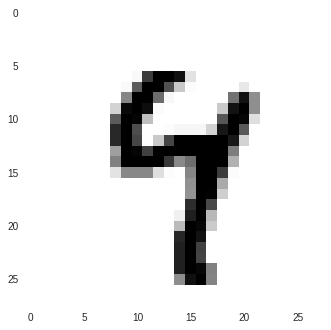

In [0]:
# show example data

# print what number this is
print('label:', mnist.train.labels[2], 'which is:', np.argmax(mnist.train.labels[2]))

# plot the image
plt.imshow(mnist.train.images[2].reshape(image_size,image_size), cmap='binary')
plt.grid(False)
plt.show()

We have split up the data randomly into 3 sets:
- training - to train the model
- validation - to check how the model is training and any hyperparameter adjustments
- testing - once fully trained, used to test accuracy, cannot tune model once tested

We're using data with 55,000 training examples, 5,000 validation and 10,000 testing

Each example has been unstacked and put into 1 row, $28\times28 = 784$

In [0]:
# show data sizes
print('training data shape', mnist.train.images.shape)
print('validation data shape', mnist.validation.images.shape)
print('testing data shape', mnist.test.images.shape)

training data shape (55000, 784)
validation data shape (5000, 784)
testing data shape (10000, 784)


### Hyperparmeters

We need to give values for everything so we can tune them later.

Hyperparams can be about:
- the structure of the Neural Net (# layers, types of layers, # nodes, etc)
- training (number of steps, minimum loss to stop training, learning rate)

In [0]:
batch_size = 100        # number of images fed in to each training step
learning_rate = 0.5     # learning rate

# epochs is number of times we feed in the data set
epochs = 2
# iterations is the number of steps we take for each epoch
iterations = mnist.train.num_examples//batch_size

### Structure

- Initiate placeholder (inputs) and variables
- Define neural network
- Training
    - Forward pass
    - Calculate Loss
    - Back Propagate
- Prediction
    - Forward pass

In [0]:
# reset session
# this is so you dont have to reset kernal and run whole notebook
# you can run from here to give tensorflow a blank canvas
tf.reset_default_graph()

### Inputs

These values are the $x$ and $y$ in $y = f(x)$

Our NN will give $\hat{y} = \hat{f}(x)$

And our loss function will use $L(y,\hat{y})$

We have placeholders for x and y, we can feed values we choose when we run the graph

In [0]:
# these are the inputs to our neural net

# the X placeholder will hold our input image
# the None in the shape means we haven't defined that dimension, it'll take what we give it
# the first dimension is the batch size (number of images for current step)
# the second is the image pixels put all in 1 row
X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')

# the Y placeholder will hold our label
# the first dimension is the batch size
# the second dimension is the one-hot encoded vector
Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

### Variables (Weights and biases)

These values are the $M$ (Weights) and $c$ (bias) in $y = Mx + c$

The Weights will be multiplied by the input and bias will be added.

We set them as tensorflow Variables so they are adjusted every training step so that $y \approx \hat f(x ; W, b)$

In [0]:
# these are the variables we will learn, they will transform our input to our predicted output

# the weights will be multiplied by the input vector
# the out put will be a vector with size 10, each element is the probability of the corresponding answer
# we would usually randomly initialize our weights, but 0's will help us visualize the later
W = tf.Variable(np.zeros([image_size**2, num_classes]), dtype=tf.float32, name='W')

# the bias will be added on the the result of the weights and input
b = tf.Variable(np.ones(shape=[num_classes]), dtype=tf.float32, name='b')

### Prediction

This is our Forward pass.

We matrix multiply $x$ and $W$ and add $b$.

- $x$, shape (1, 784)
- $W$, shape (784, 10)
- $xW$, shape (1, 10)
- $b$, shape (1, 10)

$W = \left[ \begin{array}{ccc} 
w_{1,1} & w_{1,2} & w_{1,3} & \dots & w_{1,10} \\
w_{2,1} & w_{2,2} & w_{2,3} & \dots & w_{2,10} \\
w_{3,1} & w_{3,2} & w_{3,3} & \dots & w_{3,10} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
w_{784,1} & w_{784,2} & w_{784,3} & \dots & w_{784,10} \\
\end{array} \right]$

Each element in $W$, $w_{p,k}$, has:
- row $p$ - corresponding to each pixel
- coloumn $k$ - corresponding to each class

$b = \left[ \begin{array}{ccc} 
b_{1} & b_{2} & b_{3} & \dots & b_{10}
\end{array} \right]$

$x\cdot W_{:,k} + b_k$ is the "probability" of class $k$

In [0]:
# this is the prediction

# we matrix multiply X and the weights
# we then add the bias
Y_prediction = tf.matmul(X_placeholder, W) + b

Here is another way to visualise it below.

Each $x$ value, is a pixel in the input image.

And each $k$ value, is the propability given to that class.

Each class takes in all image pixels
- multiplies them by there own weight ($w_{p,k}$ with p for each pixel and k for each class)
- and sums all the values with the same class

eg. $C_k = \sum_{p=1}^Pw_{p,k}x_{p}$

On the right, each line represent $w_{p_i,k_1}x_{p_i}$

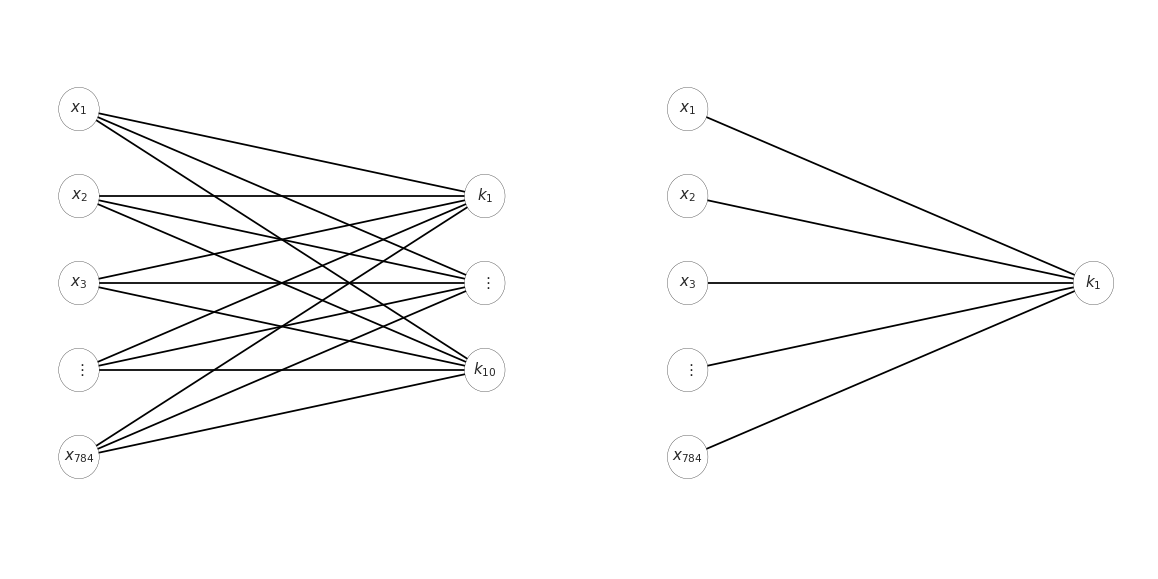

In [0]:
names = [[r'$x_{1}$',r'$x_{2}$',r'$x_{3}$',r'$\vdots$',r'$x_{784}$'],[r'$k_1$',r'$\vdots$',r'$k_{10}$']]
fig,ax = plt.subplots(1, 2,figsize=(20, 10))
ax[0].axis('off')
ax[1].axis('off')
funcs.draw_neural_net(ax[0], .1, .9, .1, .9, [5, 3], names)
funcs.draw_neural_net(ax[1], .1, .9, .1, .9, [5, 1], names)

### Loss

We are using softmax cross entropy.

Softmax ($\sigma$) changes all the predicted values into probabilities (summing to 1)

given $z = xW + b$

$\sigma(z)_j = \frac{\exp(z_j)}{\sum_{k=1}^K\exp(z_k)}$ for $j = 1,...,K$

Cross entropy is from information theory, it basically measures the difference between a predicted and true underlying discrete probability distribution.

We want to minimize it.

$H(y,\hat{y}) = -\sum_iy_i\log_2\hat{y}$

In our case, $L = -\sum_iy_i\ln\sigma(z)$

- the log prevents some underflow caused by softmax (when computer cant handle numbers too small, they will round to 0)
- information theory uses $\log_2$ (because of bits), ML uses $\ln$ (because the derivative is easy to calculate)

In [0]:
# we use softmax cross entropy as our loss function
# we input the predictions and the labels
# we then take the mean over the current batch
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder, logits=Y_prediction, name='loss'))

#### Visualising softmax

Below we have 4 graphs, 1 contains the outputs from the NN, and 3 with different normalization techniques.

Softmax benifits:
- It normalizes it so it sums to 1
- We can easily differentiate it, unlike hardmax
- It's close to hardmaxunlike standard normalization, which is optimal for a perfect model
- It considers the values and not just the ratios of the values
    - bigger values make bigger differences (because of exp)
    - our model outputs values based on probability of this class, not based on all classes
        (they are still optimized based on differences in classes though)
        
For more information on softmax and cross entropy (and finding their derivatives), go [here](https://deepnotes.io/softmax-crossentropy)

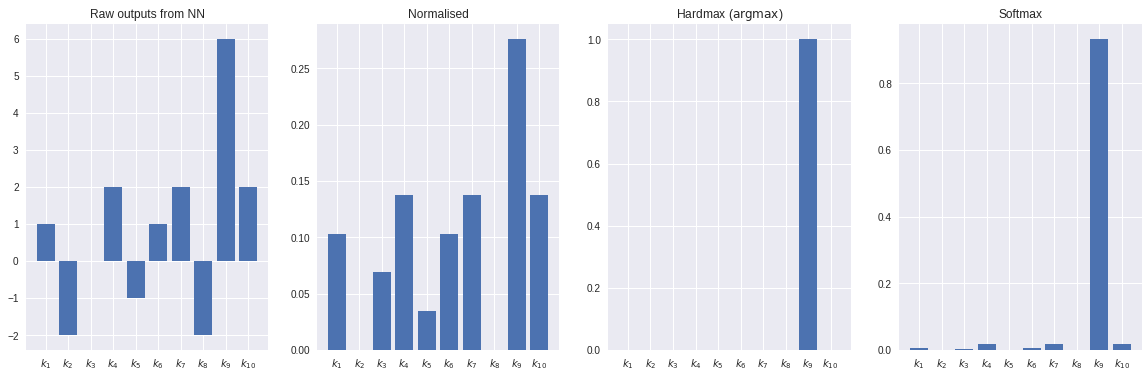

In [0]:
fig,ax = plt.subplots(1, 4, figsize=(20,6))
funcs.softmax_graphs(ax)

### Gradient Descent and Backpropagation

Now we need to update the weights to give a better prediction.

We use gradient descent, which is a learning method and backpropagation which is a computational trick to calculate gradients.

Given a loss function $L(y, \hat{f}(x ; W, b))$, we want to decrease it based on changing W and b, our variables.

We dont know what variable values give us the smallest loss possible, but we do know how to decrease to loss.

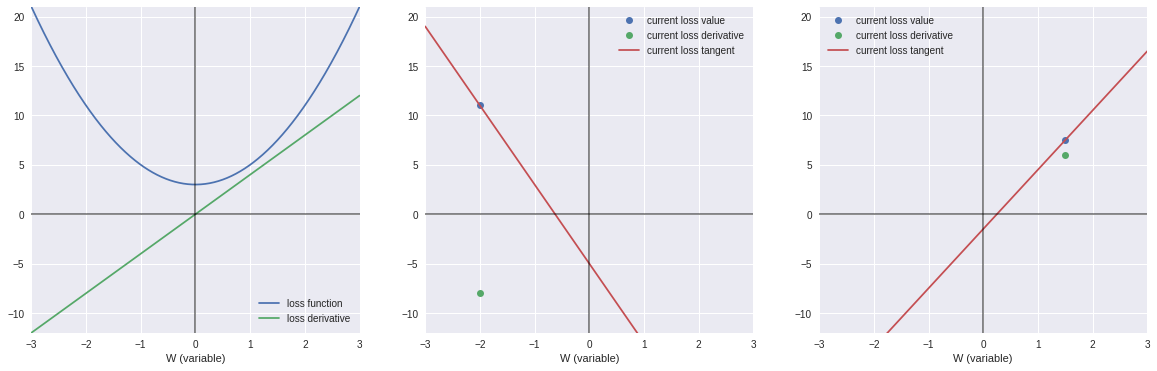

In [0]:
fig,ax = plt.subplots(1, 3, figsize=(20,6))
funcs.loss_optimization(ax)

In the plot above, we can see that if we pick a point on the loss line, to decrease it we subtract the derivative.

$W_{(t+1)} = W_{(t)} - \epsilon L_W\prime$

This is the basic principal of what we're doing, except we're using many more variables and (not in our case) more layers.

- when using multiple variables, we calculate the partial derivative, which is the derivative based on 1 variable out of all of them
- when using multiple functions (which we are), we use the chain rule

For a more in depth, intro to gradient descent and back propagation, watch this [playlist](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

In [0]:
# we define a training step
# we're using the simplest optimizer, gradient descent to minimize the loss
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

### Calculating accuracy

This doesn't add anything to the NN, it's just useful to see.

It simply calculates what fraction of predictions were correct

In [0]:
# for each input image, return a boolean whether it was correct or not
correct_prediction = tf.equal(tf.argmax(Y_prediction, 1), tf.argmax(Y_placeholder, 1))

# turn bools into 1's or 0's, then calculate mean to give accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Tensorflow graphs and sessions

With Tensorflow, we first create the graph by defining everything above, and then create a session which allows us to run that graph feeding in data to our placeholders.

This means we're creating a static graph, which once defined, cant be changed.

We can only run the functions with real data with our session.

We also have initialize all variables before running anything else.

In [0]:
# Initialize our session
sess = tf.InteractiveSession()

# Initialize our variables
sess.run(tf.global_variables_initializer())

### Training

We now get to train our model.

We repeat for a set number of iterations:
- get new batch of data
- call train function using corresponding x and y batches
    - this runs the forward pass
    - then calculates the loss
    - then backprobagates
- show progress
    - current batch loss shows whether the loss is decreasing
    - accuracy with validation set shows how it generalizes, we can also tune hyperparams during training (not in our case)

In [0]:
# initialize empty array to hold losses for each training step
losses = np.array([])

# loop over each epoch
for epoch in range(epochs):
    
    # print number epoch
    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    # loop over number of iterations
    for idx in range(iterations):

        # get batches of training data for current step
        batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)

        # run training step and get loss values to plot later
        _, _loss = sess.run([train_step, loss], 
                            feed_dict={
                                X_placeholder: batch_xs,
                                Y_placeholder: batch_ys
                            })

        # print current feedback every few steps during training
        if (idx+1) % (iterations/5) == 0:

            # get accuracy using validation set
            # we are only doing the forward pass, no training (back propagation) is happening
            _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation.images,
                                                      Y_placeholder : mnist.validation.labels
                                                     })

            # print current step, batch loss and validation accuracy
            print('step', str(idx+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')

        # append the loss to the losses array to plot
        losses = np.append(losses, _loss)

New epoch 1/2
step 110/550 loss 0.61368734 accuracy 89.14%
step 220/550 loss 0.31972912 accuracy 90.62%
step 330/550 loss 0.3507457 accuracy 90.9%
step 440/550 loss 0.29813647 accuracy 91.36%
step 550/550 loss 0.3443647 accuracy 91.9%
New epoch 2/2
step 110/550 loss 0.31651098 accuracy 91.96%
step 220/550 loss 0.22183949 accuracy 92.04%
step 330/550 loss 0.32235673 accuracy 91.4%
step 440/550 loss 0.48249054 accuracy 92.5%
step 550/550 loss 0.21012774 accuracy 91.86%


Now training has finished, we can see how the NN trained.

The loss graph is below, it should decreasing quickly at first and then less until it levels off.

It will also have a lot of noise as each mini batch doesnt perfectly represent the whole training data set.

In [0]:
# plot training losses

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

### Testing

We now need to test.

We cant use any data that we've used to train on because the model could be overfit.

We cant use any validation data, as we could have tuned the hyperparams to fit this set.

We use a brand new testing set and show the accuracy.



In [0]:
# find accuracy on test set
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels
                                         })

print(str(round(100*_accuracy,2))+'%')

92.15%


Lets also see a single image, and see the probability assigned to each class

prediction: 2 answer: 2
0 0.16%
1 0.001%
2 98.06%
3 0.404%
4 0.0%
5 0.449%
6 0.754%
7 0.0%
8 0.173%
9 0.0%


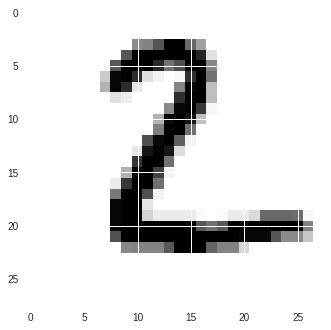

prediction: 6 answer: 6
0 0.291%
1 0.038%
2 6.45%
3 1.55%
4 0.464%
5 0.162%
6 77.788%
7 0.002%
8 13.186%
9 0.068%


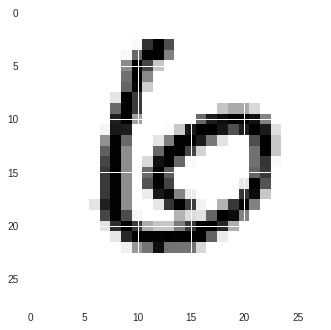

In [0]:
# try and show test images with prediction probabilities

# we're using these images and corresponding labels index's
test_idxs = [1,11]

# loop for each test image
for test_idx in test_idxs:
    # get input image and corresponding label
    test_x, test_y = mnist.test.images[test_idx], mnist.test.labels[test_idx]

    # find the prediction
    # we need to reshape the input to a 2d matrix even though its only 1 row
    # this is because we only have 1 input image in our batch
    _prediction = sess.run(Y_prediction, feed_dict={X_placeholder: test_x.reshape(1,-1)})

    # show prediction and true answer
    print('prediction:', np.argmax(_prediction), 'answer:', np.argmax(test_y))

    # show probabilities for all values
    for i,val in enumerate(_prediction[0]):
        print(i, str(round(100*np.exp(val)/np.sum(np.exp(_prediction)),3))+'%')

    # plot test image
    plt.imshow(test_x.reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()

### Visualising the weights

How are the weights predicting the number by multiplication?

Below are the weights for each class in the same shape as the images.

Each pixel in the image and its corresponding weight pixel is multiplied.

If the weight pixel has a positive value where the image has a high value, the probability of this class goes up.

If the weight pixel has a negative value where the image has a high value, the probability of this class goes down.

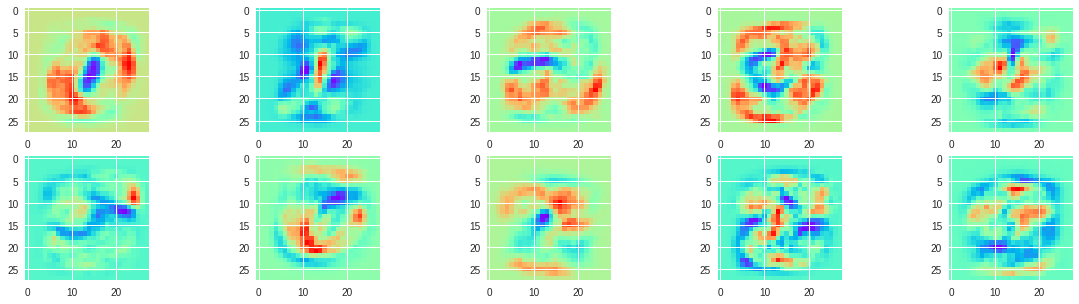

In [0]:
# get our weights
_W = sess.run(W)

fig,ax = plt.subplots(2,5,figsize=(20,5))

for i in range(ax.size):
    # plot each weight vector in the same shape as the images
    ax[i//5,i%5].imshow(_W[:,i].reshape(image_size,image_size), cmap='rainbow')
    ax[i//5,i%5].grid(False)

One thing to remember though, it doesn't learn the distribution of the class, it learns the difference between the classes.

This means it's a Discriminative model, a generative model would learn how the data was made.